#### *ISEL - DEI - LEIM*
## Aprendizagem Automática [T52D]
### Trabalho Laboratorial 2: Classificação de Críticas de Cinema do IMDb

João Madeira ($48630$), 
Renata Góis ($51038$),
Bruno Pereira ($51811$)

**Docentes responsáveis:** 
- Prof. Gonçalo Xufre Silva

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pickle as p
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, silhouette_score
import sklearn.preprocessing as pp
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

In [53]:
with open("resources/imdbFull.p", "rb") as f:
    D = p.load(f)
print("Keys:", D.keys())

reviews = D['data']
sentiments = D['target']

print(len(reviews), "reviews")

Keys: dict_keys(['data', 'target', 'DESCR'])
50000 reviews


In [27]:
def class_stats(target, predicted, title=""):
    cm = confusion_matrix(target, predicted)
    accuracy = accuracy_score(target, predicted)
    precision = precision_score(target, predicted,average="macro")
    recall = recall_score(target, predicted,average="macro")

    print(title)
    print("Accuracy:", np.round(accuracy*100,2),"%")
    print("Precision:", np.round(precision*100,2),"%")
    print("Recall:", np.round(recall*100,2),"%")
    print(f"Matriz de confusão : \n",cm)
    
def reg_stats(target, predicted, title=""):
    mae = mean_absolute_error(target, predicted)
    mse = mean_squared_error(target, predicted)
    r2 = r2_score(target, predicted)
    
    y_aux = np.round(predicted)
    y_aux[y_aux > 10.] = 10.
    y_aux[y_aux < 1.] = 1.
    y_aux[y_aux == 5.] = 4.
    y_aux[y_aux == 6.] = 7.
    cm = confusion_matrix(target, y_aux)
    accuracy = accuracy_score(target, y_aux)
    
    print(title)
    print("erro quadrático absoluto :",np.round(mae,2))
    print("erro quadratico medio :",np.round(mse,2))
    print("R2 :",np.round(r2,2))
    print("Accuracy:", np.round(accuracy*100,2),"%")
    print("Matriz de confusão :\n",cm)
    
def cluster_top_words(vectorizer, kmeans, word_count=10):
    terms = vectorizer.get_feature_names_out()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    for i in range(len(order_centroids)):
        print(f"\n\nCluster {i+1} top {word_count} words:")
        for ind in order_centroids[i, :word_count]:
            print(terms[ind], end=" | ")
            
def cluster_metrics(data, clusters, sample_size=2000):
    
    if data.shape[0] > sample_size:
        idx = np.random.choice(data.shape[0], sample_size, replace=False)
        sil = silhouette_score(data[idx], clusters[idx])
    else:
        sil = silhouette_score(data, clusters)

    unique, counts = np.unique(clusters, return_counts=True)

    print("\nSilhouette score (amostrado):", sil, "\n")
    for i in range(len(unique)):
        print(f"Cluster {unique[i]+1}  nº críticas: {counts[i]}")

    plt.bar(unique+1, counts)
    plt.xlabel("Cluster")
    plt.ylabel("Número de críticas")
    plt.title("Distribuição das críticas por cluster")
    plt.xticks(unique+1)
    plt.show()
    

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.
For more details see: http://ai.stanford.edu/~amaas/data/sentiment/

### **1.** Pré-processamento e Limpeza de Texto
O objetivo desta etapa foi reduzir o ruído e a dimensionalidade do vocabulário, mantendo o conteúdo semântico relevante.

**Stemming:** Aplicou-se o algoritmo `SnowballStemmer` para reduzir as palavras à sua raiz lexical, permitindo agrupar variações da mesma palavra.

In [ ]:
stemmer = SnowballStemmer("english")

def clean_review(string):
    # Remove tags HTML
    string = string.replace('<br />', ' ')  
    # Remove palavras com 20 ou mais caracteres
    string = re.sub(r'\b[a-zA-Z]{20,}\b', ' ', string)
    # Remove palavras com 3 ou mais letras repetidas consecutivamente (e.g., "yaaass", "omgggg")
    string = re.sub(r'\b\w*(.)\1{2,}\w*\b', ' ', string)
    # Filtra apenas letras
    string = re.sub(r'[^a-zA-Z]', ' ', string)
    # Remove espaços consecutivos
    string = re.sub(r'\s+', ' ', string).strip()
    # Normaliza para minúsculas
    string = string.lower()
    # Aplica Stemming
    string = " ".join(stemmer.stem(w) for w in string.split())
    return string

reviews = [clean_review(rev) for rev in reviews]

output = {"data" : reviews, "target" : sentiments}
p.dump(output,open("resources/imdbPreProcessed.p",'wb'))

### **2.** Construção do Vocabulário (TF-IDF)
Configurou-se o `TfidfVectorizer` da seguinte forma:
- **N-grams (1,2):** Incluíram-se bigramas para capturar contexto local (ex: "*not good*").

- **Stop-words:** Personalizou-se a lista de exclusão para **manter** termos de negação (como "*no*" e "*not*"), necessários para a inversão de polaridade, que seriam removidos por defeito.

- **Limites:** Definiram-se `min_df=3` e `max_features=30k` para eliminar erros ortográficos pontuais e controlar o uso de memória.

In [6]:
custom_stopwords = list(ENGLISH_STOP_WORDS - {'no', 'not', 'nor'})

tfidfVector = TfidfVectorizer(min_df=3,                    # Remove palavras que aparecem menos de 10 vezes no dataset
                        max_df=0.8,                        # Remove palavras que aparecem em 90% do dataset 
                        max_features=30000,                # Limita o maximo de features para 30.000
                        ngram_range=(1,2),                 # Utiliza unigramas e bigramas (good, very good, pretty bad)
                        token_pattern=r'\b[a-zA-Z]{2,}\b', # Ignora palavras com menos de 2 letras
                        sublinear_tf=True,                 # Term frequency passa a ter um comportamento logarítmico em vez de linear
                        stop_words=custom_stopwords        # Remove stopwords em inglês excepto "no", "not" e "nor"
                        )

In [7]:
pre_processed_data = p.load(open("resources/imdbPreProcessed.p","rb"))
reviews = pre_processed_data['data']
sentiments = pre_processed_data['target']

tfidfVector = tfidfVector.fit(reviews)

tokens = tfidfVector.get_feature_names_out()
X = tfidfVector.transform(reviews)
# X.astype(np.float32) # reduz para metade a utilização de RAM
len(tokens)

30000

### **3.** Divisão em conjuntos de treino, teste e validação
Realizou-se a partição do *dataset* em três subconjuntos: **treino**, **teste** e **validação**. Utilizou-se amostragem estratificada (`stratify`) para garantir que a distribuição original das classes de *rating* ($1$ a $10$) fosse preservada proporcionalmente em todos os subconjuntos.

| Treino | Teste | Validação |
|--|--|--|
|40k (80%)|5k (10%)|5k (10%)|

In [8]:
# Split 80% treino / 20% temporário (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, sentiments,
    test_size=0.2,
    random_state=42,
    stratify=sentiments
)

# Split 50% validação, 50% teste (10% / 10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

### **4.** Classificação e Regressão

#### **4.1** Classificação
Optou-se por testar os modelos **LogisticRegression**, **LinearSVC** e **Random Forest**

### LogisticRegression

* **Otimização:** Efetuou-se uma pesquisa em grelha (`GridSearchCV`) com validação cruzada (`cv=3`) para determinar o valor ideal do parâmetro de regularização `C`.

* **Regularização:** Manteve-se a penalização L2 para mitigar o risco de *overfitting*.

In [115]:
param_grid = {
    'penalty': ['l2'],
    'solver': ['saga'],
    'C': [1, 2, 5],
    'max_iter': [50,100]
}

grid_search = GridSearchCV(LogisticRegression(random_state=42, n_jobs=1), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'saga'}


In [6]:
lr = LogisticRegression(penalty='l2', solver='saga', C=1, max_iter=50, random_state=42)
lr = lr.fit(X_train, y_train)

In [9]:
predicted_lrtest = lr.predict(X_test)

class_stats(y_test, predicted_lrtest, "Conjunto de Teste")

Conjunto de Teste
Accuracy: 43.62 %
Precision: 35.05 %
Recall: 34.28 %
Matriz de confusão : 
 [[833  48  46  35   7   8   4  31]
 [274  32  50  62  11  11   2  17]
 [201  25  80 104  21  22   7  36]
 [140  21  66 165  43  25   8  65]
 [ 28   6  11  45 121 116  21 132]
 [ 20   3   7  29 101 164  20 242]
 [ 12   1   7   8  38  87  34 274]
 [ 42   2   8   7  34  95  33 752]]


In [10]:
predicted_lrval = lr.predict(X_val)

class_stats(y_val, predicted_lrval, "Conjunto de Validação")

Conjunto de Validação
Accuracy: 43.14 %
Precision: 34.6 %
Recall: 34.08 %
Matriz de confusão : 
 [[811  37  48  57   6  11   4  38]
 [259  35  44  75  10   8   2  25]
 [184  37  87 118  20  21   4  25]
 [125  19  78 184  49  27   7  44]
 [ 26   7  22  42 126 115  16 127]
 [ 25   4   9  31 104 126  33 254]
 [ 11   2   8  10  33  84  36 277]
 [ 36   2   3  15  33  96  36 752]]


### LinearSVC

In [11]:
param_grid = {
    'C': [0.1, 1, 2, 5],
    'max_iter': [2000, 5000, 10000]
}

grid_search = GridSearchCV(LinearSVC(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 0.1, 'max_iter': 2000}


In [12]:
lsvc = LinearSVC(random_state=42, C=0.1, max_iter=2000)
lsvc = lsvc.fit(X_train, y_train)

In [13]:
predicted_svctest = lsvc.predict(X_test)

class_stats(y_test, predicted_svctest,"Conjunto de Teste")

Conjunto de Teste
Accuracy: 43.12 %
Precision: 34.29 %
Recall: 32.74 %
Matriz de confusão : 
 [[869  25  32  32   5   9   3  37]
 [312  22  31  55   8  10   2  19]
 [228  21  61  95  21  18   5  47]
 [172  18  55 151  38  22   8  69]
 [ 30   6  12  40 108 108  15 161]
 [ 24   3   7  28  90 122  14 298]
 [ 17   1   1   7  34  63  24 314]
 [ 44   1   5   7  29  70  18 799]]


In [14]:
predicted_svcval = lsvc.predict(X_val)

class_stats(y_val, predicted_svcval,"Conjunto de Validação")

Conjunto de Validação
Accuracy: 43.74 %
Precision: 34.45 %
Recall: 33.5 %
Matriz de confusão : 
 [[864  24  27  39   6   9   3  40]
 [307  20  25  62   9   6   1  28]
 [231  22  71 108  17  13   4  30]
 [150  17  67 172  44  23   8  52]
 [ 32   4  14  40 119 107   7 158]
 [ 30   3   9  22  96 115  23 288]
 [ 15   2   6  10  28  67  21 312]
 [ 36   1   3  12  27  67  22 805]]


In [ ]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None],
    "min_samples_split": [2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
# não foi possivel obter um resultado com o grid search

In [16]:
rfc = RandomForestClassifier(random_state=42, n_estimators= 200, max_depth= None, min_samples_split= 2)
rfc = rfc.fit(X_train, y_train)

In [17]:
predicted_rfctest = rfc.predict(X_test)

class_stats(y_test, predicted_rfctest,"Conjunto de Teste")

Conjunto de Teste
Accuracy: 37.88 %
Precision: 46.16 %
Recall: 25.16 %
Matriz de confusão : 
 [[916   0   2   6   2   5   0  81]
 [382   5   2   5   2   3   0  60]
 [346   0  12  18   2   5   0 113]
 [302   0   9  29   5  14   0 174]
 [101   0   1  14  28  37   0 299]
 [ 81   0   4   7  15  42   0 437]
 [ 38   0   1   6   5  23   2 386]
 [ 83   0   0   2   7  19   2 860]]


In [18]:
predicted_rfcval = rfc.predict(X_val)

class_stats(y_val, predicted_rfcval,"Conjunto de Validação")

Conjunto de Validação
Accuracy: 38.52 %
Precision: 53.39 %
Recall: 25.94 %
Matriz de confusão : 
 [[917   0   1   5   0   3   0  86]
 [363   6   4  10   0   1   0  74]
 [365   0  17  17   3   6   0  88]
 [323   0   6  41   8  18   0 137]
 [ 94   0   4  18  30  49   1 285]
 [ 95   0   2   7  16  49   0 417]
 [ 38   0   0   2   7  24   8 382]
 [ 84   0   0   3   6  22   0 858]]


#### **4.2** Classificação
Optou-se por testar os regressores **Lasso**, **Ridge** e **Gradient Boosting Regressor**

### Lasso

In [ ]:
param_grid = {
    "alpha": [0.001,1], 
    "max_iter": [40, 50]
}

grid_search = GridSearchCV(Lasso(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'alpha': 0.001, 'max_iter': 40}


In [19]:
lasso = Lasso(alpha = 0.001, max_iter=40, random_state=42)
lasso.fit(X_train,y_train)

,alpha,0.001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,40
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [21]:
predicted_lassotest = lasso.predict(X_test)

reg_stats(y_test,predicted_lassotest,"Conjunto de Teste")

Conjunto de Teste
erro quadrático absoluto : 1.97
erro quadratico medio : 5.61
R2 : 0.54
Accuracy: 21.42 %
Matriz de confusão :
 [[165 175 193 382  90   6   0   1]
 [ 41  56  82 211  64   3   2   0]
 [ 28  30  82 235 117   3   1   0]
 [ 11  30  49 239 189  13   2   0]
 [  0   2   3  93 293  72  13   4]
 [  0   0   3  78 328 110  49  18]
 [  0   0   0  29 225 125  58  24]
 [  0   1   2  72 430 255 145  68]]


In [22]:
predicted_lassoval = lasso.predict(X_val)

reg_stats(y_val,predicted_lassoval,"Conjunto de Validação")


Conjunto de Validação
erro quadrático absoluto : 1.94
erro quadratico medio : 5.49
R2 : 0.55
Accuracy: 22.1 %
Matriz de confusão :
 [[181 154 210 369  96   1   1   0]
 [ 43  56  77 213  68   1   0   0]
 [ 15  38  71 266 100   6   0   0]
 [ 13  22  62 269 158   7   2   0]
 [  0   2   1 110 278  65  23   2]
 [  0   1   1  74 331 121  44  14]
 [  0   0   0  36 225 128  51  21]
 [  0   1   5  69 438 253 129  78]]


### Ridge

In [52]:
param_grid = {
    "alpha" : [1, 2, 3],
    "max_iter" : [50, 100, 500],
    'solver': ['lsqr', 'sparse_cg', 'sag', 'auto']
}

grid_search = GridSearchCV(Ridge(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'alpha': 2, 'max_iter': 50, 'solver': 'sparse_cg'}


In [23]:
ridge = Ridge(alpha = 2, max_iter=50, solver="sparse_cg", random_state=42)
ridge.fit(X_train,y_train)

,alpha,2
,fit_intercept,True
,copy_X,True
,max_iter,50
,tol,0.0001
,solver,'sparse_cg'
,positive,False
,random_state,42


In [24]:
predicted_ridgetest = ridge.predict(X_test)

reg_stats(y_test,predicted_ridgetest,"Conjunto de Teste")

Conjunto de Teste
erro quadrático absoluto : 1.63
erro quadratico medio : 4.13
R2 : 0.66
Accuracy: 27.24 %
Matriz de confusão :
 [[255 229 221 258  47   1   1   0]
 [ 66  86 108 164  31   3   1   0]
 [ 46  61 100 206  78   5   0   0]
 [ 22  44  74 256 123  10   4   0]
 [  0   1   6  68 267  84  43  11]
 [  0   0   2  41 266 123 107  47]
 [  0   0   1  25 154 128  98  55]
 [  0   2   2  45 286 233 228 177]]


In [25]:
predicted_ridgeval = ridge.predict(X_val)

reg_stats(y_val,predicted_ridgeval,"Conjunto de Validação")

Conjunto de Validação
erro quadrático absoluto : 1.61
erro quadratico medio : 4.03
R2 : 0.67
Accuracy: 27.86 %
Matriz de confusão :
 [[270 200 255 238  45   2   1   1]
 [ 68  79 110 168  31   2   0   0]
 [ 40  54 121 224  51   5   1   0]
 [ 17  40  93 258 112  10   3   0]
 [  0   1   3  89 244  87  47  10]
 [  0   1   1  51 267 137  84  45]
 [  0   0   1  22 140 133 112  53]
 [  0   2   3  47 276 253 220 172]]


### Gradient Boosting Regressor

In [77]:
param_grid = {
    "n_estimators": [100],
    "learning_rate": [0.05],
    "max_depth": [3,4],
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [9]:
gbr = GradientBoostingRegressor(n_estimators = 100, learning_rate=0.05, max_depth=4, random_state=42)
gbr.fit(X_train,y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


In [10]:
predicted_gbrtest = gbr.predict(X_test)

reg_stats(y_test,predicted_gbrtest,"Conjunto de Teste")

Conjunto de Teste
erro quadrático absoluto : 2.2
erro quadratico medio : 6.7
R2 : 0.45
Accuracy: 16.6 %
Matriz de confusão :
 [[ 46 175 267 357 160   7   0   0]
 [  9  55  85 190 116   4   0   0]
 [  6  34  66 223 162   5   0   0]
 [  0  19  58 224 222   9   1   0]
 [  0   0  10  89 339  39   3   0]
 [  0   0   6  82 398  94   6   0]
 [  0   0   3  40 308 104   6   0]
 [  0   2   7  72 600 256  36   0]]


In [11]:
predicted_gbrval = gbr.predict(X_val)

reg_stats(y_val,predicted_gbrval,"Conjunto de Validação")

Conjunto de Validação
erro quadrático absoluto : 2.22
erro quadratico medio : 6.81
R2 : 0.44
Accuracy: 17.2 %
Matriz de confusão :
 [[ 57 169 256 359 170   1   0   0]
 [  9  50  92 196 109   2   0   0]
 [  4  21  67 244 155   5   0   0]
 [  2  15  60 236 212   8   0   0]
 [  0   1   5 101 322  50   2   0]
 [  0   1   3  88 376 111   7   0]
 [  0   0   3  42 300  99  17   0]
 [  0   0   7  86 616 244  20   0]]


## Clustering

In [24]:
km2clusters = KMeans(n_clusters=2, random_state=42, n_init=10)
km2cLabels = km2clusters.fit_predict(X)



Cluster 1 top 20 words:
movi | not | like | just | watch | bad | film | good | realli | don | make | time | no | think | act | becaus | look | thing | peopl | say | 

Cluster 2 top 20 words:
film | not | movi | stori | veri | charact | time | like | great | love | make | play | good | just | scene | perform | life | best | no | work | 
Silhouette score (amostrado): 0.001504685040344664 

Cluster 1  nº críticas: 22054
Cluster 2  nº críticas: 27946


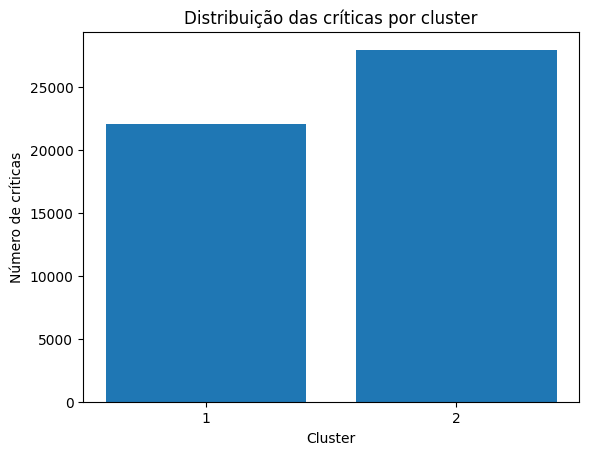

In [30]:
cluster_top_words(tfidfVector,km2clusters,20)
cluster_metrics(X,km2cLabels,sample_size=5000)

Testámos com 4 clusters mas pelas top 20 palavras não era possivél fazer uma identificação para além de criticas positivas e negativas á semelhança do clustering com 2 clusters

In [31]:
km8clusters = KMeans(n_clusters=8, random_state=42, n_init=10)
km8cLabels = km8clusters.fit_predict(X)



Cluster 1 top 20 words:
funni | comedi | movi | laugh | not | joke | film | like | just | good | veri | watch | time | realli | make | humor | charact | don | think | hilari | 

Cluster 2 top 20 words:
film | not | movi | perform | play | veri | stori | great | good | charact | like | time | best | cast | make | scene | love | role | actor | just | 

Cluster 3 top 20 words:
movi | like | just | film | not | no | make | look | realli | guy | thing | bad | charact | don | end | scene | good | time | peopl | becaus | 

Cluster 4 top 20 words:
movi | watch | not | great | love | like | good | veri | stori | realli | just | time | think | film | enjoy | charact | don | did | make | saw | 

Cluster 5 top 20 words:
episod | seri | season | tv | watch | like | charact | not | just | time | good | veri | great | best | realli | love | end | stori | new | tv seri | 

Cluster 6 top 20 words:
film | not | life | stori | charact | movi | make | veri | time | live | like | peopl | man | world | lo

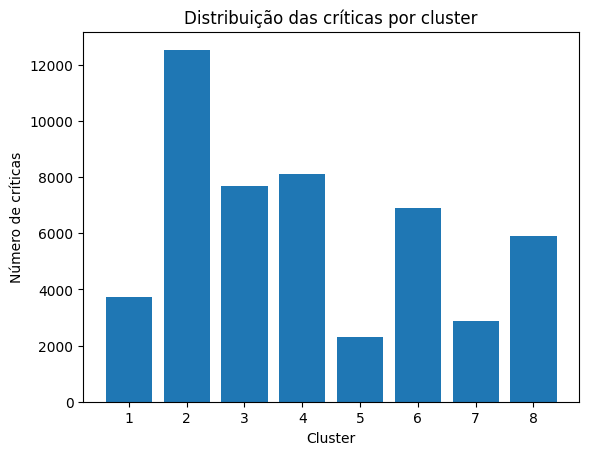

In [32]:
cluster_top_words(tfidfVector,km8clusters,20)
cluster_metrics(X,km8cLabels)

In [33]:
km20clusters = KMeans(n_clusters=20, random_state=42, n_init=10)
km20cLabels = km20clusters.fit_predict(X)



Cluster 1 top 20 words:
year | movi | saw | ago | old | year ago | year old | film | watch | rememb | time | love | dvd | not | saw movi | like | just | kid | seen | copi | 

Cluster 2 top 20 words:
sci fi | sci | fi | movi | film | like | not | effect | good | fi channel | fi movi | watch | just | make | bad | time | space | alien | look | realli | 

Cluster 3 top 20 words:
movi | like | not | film | just | no | look | watch | scene | make | time | plot | good | charact | end | guy | act | bad | thing | tri | 

Cluster 4 top 20 words:
war | film | world war | soldier | world | movi | not | german | american | time | stori | dure | like | veri | no | battl | year | just | scene | make | 

Cluster 5 top 20 words:
episod | seri | season | tv | watch | charact | not | like | just | time | good | veri | great | end | best | realli | love | stori | everi | televi | 

Cluster 6 top 20 words:
martial | martial art | fight | kung | kung fu | fu | art | action | movi | fight scene | jacki | c

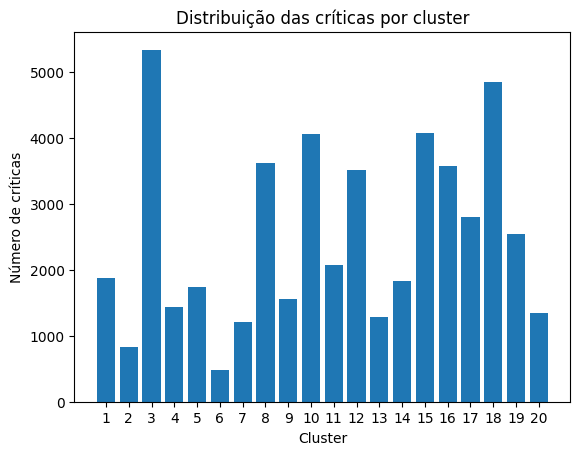

In [34]:
cluster_top_words(tfidfVector,km20clusters,20)
cluster_metrics(X,km20cLabels)

In [ ]:
km25clusters = KMeans(n_clusters=25, random_state=42, n_init=10)
km25cLabels = km25clusters.fit_predict(X)



Cluster 1 top 20 words:
episod | seri | season | watch | tv | charact | like | not | just | time | good | veri | great | end | realli | best | stori | everi | think | new | 

Cluster 2 top 20 words:
sci fi | sci | fi | movi | film | like | not | good | effect | fi channel | fi movi | watch | just | bad | make | time | space | look | alien | channel | 

Cluster 3 top 20 words:
movi | great | love | film | best | watch | stori | veri | time | enjoy | good | not | like | just | perform | act | wonder | charact | actor | seen | 

Cluster 4 top 20 words:
wast | wast time | movi | time | don wast | money | don | not | watch | film | just | bad | no | act | like | make | good | plot | wast money | time money | 

Cluster 5 top 20 words:
film | movi | not | like | no | charact | just | make | plot | watch | ani | act | good | look | scene | time | actor | realli | end | stori | 

Cluster 6 top 20 words:
horror | film | horror movi | movi | horror film | gore | not | like | good | just | make 

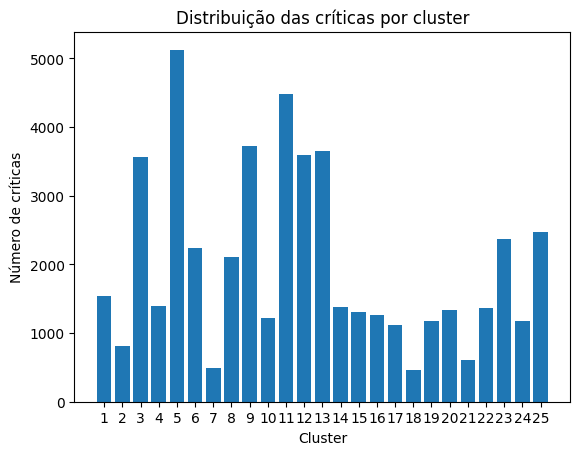

In [28]:
cluster_top_words(tfidfVector,km25clusters,20)
cluster_metrics(X,km25cLabels)

## Análise de resultados

### Classificação

| |Logistic Regression | Linear SVC |
|-|-|-|
|Accuracy|<div class="alert alert-danger"><center>43.14 % |<div class="alert alert-success"><center>43.74 % |
|Precision|<div class="alert alert-success"><center>34.6 % |<div class="alert alert-danger"><center>34.45 % |
|Recall|<div class="alert alert-success"><center>34.08 % |<div class="alert alert-danger"><center>33.5 %|


### Regressão
| |<center>Lasso | <center>Ridge | <center>GradientBoosting |
|-|-|-|-|
|Accuracy|<div class="alert alert-warning"><center>22.1 % |<div class="alert alert-success"><center>27.86 % |<div class="alert alert-danger"><center>17.2 %|
|Mean Squared Error|<div class="alert alert-warning"><center>5.49|<div class="alert alert-success"><center>4.03|<div class="alert alert-danger"><center>6.81|
|R2 Score|<div class="alert alert-warning"><center>0.55|<div class="alert alert-success"><center>0.67|<div class="alert alert-danger"><center>0.44|



## Clustering

## 2 Clustes

É possivél observar através das 20 palavras mais utilizadas que um cluster possúi uma conotação negativa e o outro positiva
|positivas|negativas|
|-|-|
| 55.89%| 44.11%|

## 4 Clusters

Observou-se através das 20 palavras mais utilizadas que a divisão era ambigua e á semelhança do clustering de 2 baseava-se em palavras com conotação positiva e negativa.<br>
Desta forma decidimos ignorar este caso pois não acrescenta nada ao estudo.

## 8 Clusters

A partir daqui foi possivel começar a atribuir tópicos aos clusters através da interpretação das palavras mais frequentes.<br>
Clusters cujas palavras mais frequentes não forneciam informação para daterminar um tópico ou apenas forneciam palavras com conotação positiva ou negativa foram deixados como "?".
|Cluster | <center>1 | <center>2 | <center>3 | <center>4 | <center>5 | <center>6 | <center>7 | <center>8 |
|-|-|-|-|-|-|-|-|-|
|Tópico | Filmes de comédia | ? | ? | ? | Séries | ? | Filmes de Terror | ? |

## 20 Clusters

|Cluster | <center>1 | <center>2 | <center>3 | <center>4 | <center>5 | <center>6 | <center>7 | <center>8 | <center>9 | <center>10 | <center>11 | <center>12 | <center>13 | <center>14 | <center>15 | <center>16 | <center>17 | <center>18 | <center>19 | <center>20 |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Tópico | ? | Filmes Sci-Fi | ? | Filmes de Guerra | Séries | Filmes de ação/artes marciais | Filmes com baixo orçamento | ? | Desperdício de tempo e dinheiro | ? | Filmes de terror | ? | Filmes de animação | ? | ? | ? | ? | ? | Filmes de comédia | Musicais |

## 25 Clusters

|Cluster | <center>1 | <center>2 | <center>3 | <center>4 | <center>5 | <center>6 | <center>7 | <center>8 | <center>9 | <center>10 | <center>11 | <center>12 | <center>13 | <center>14 | <center>15 | <center>16 | <center>17 | <center>18 | <center>19 | <center>20 |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Tópico | Séries | Filmes Sci-fi | ? | Desperdício de tempo/dinheiro | ? | Filmes de terror | Filmes de Ação/Artes marciais | Filmes sobre família | ? | Filmes de animação | ? | ? | ? | Piores filmes | ? | Musicais | Adaptações de livros | Filmes festivos | ? | Documentarios |

|Cluster | <center>21 | <center>22 | <center>23 | <center>24 | <center>25 |
|-|-|-|-|-|-|
|Tópicos |Adaptações de Video-jogos | Filmes de guerra | ? | Filmes +18 | Filmes de Comédia|